In [ ]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.efficientnet import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [ ]:
#Extracting the zipped archive into the folder in which I am 
!unzip -q ../gdrive/MyDrive/ANNDL/Homework1/training_dataset_homework1.zip

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import os
import random

!pip install split-folders

import splitfolders
dataset_dir = '/content/splitted'

splitfolders.ratio('training_data_final', output=dataset_dir, seed=seed, ratio=(.85, .15), group_prefix=None) # default values

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 3542 files [00:00, 7087.12 files/s]


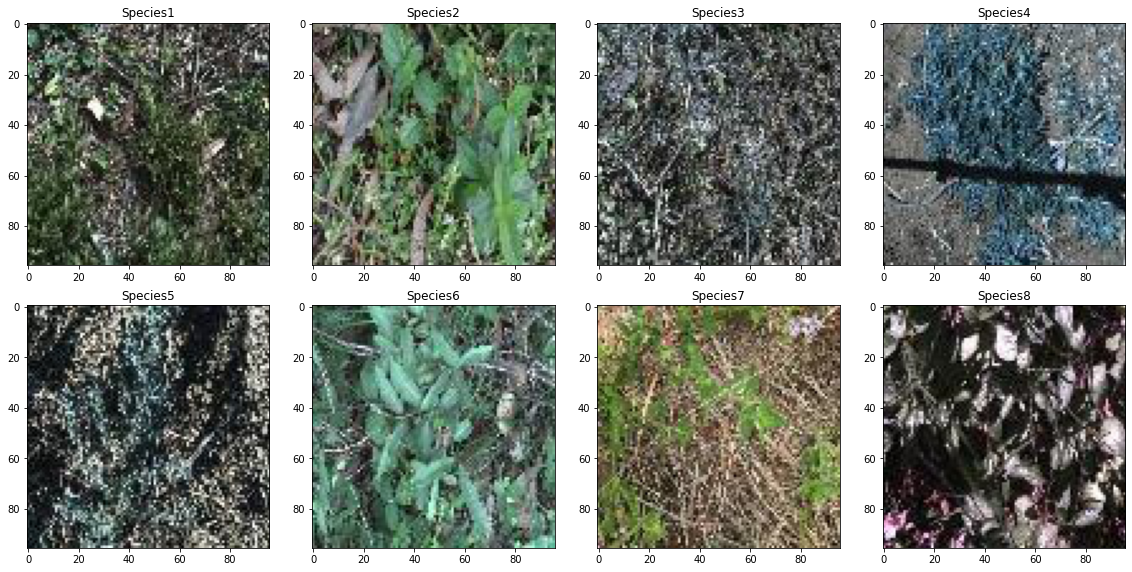

In [ ]:
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Plot example images from dataset
labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8']

from tensorflow.keras.utils import to_categorical



num_row = len(labels)//3
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(8*num_row,2*num_col))
for i in range(len(labels)):
  class_imgs = next(os.walk('{}/train/{}/'.format(dataset_dir, labels[i])))[2]
  class_img = class_imgs[0]
  img = Image.open('{}/train/{}/{}'.format(dataset_dir, labels[i], class_img))
  #print(np.array(img))
  ax = axes[i//num_col, i%num_col]
  ax.imshow(np.array(img))
  ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

456


Text(0.5, 1.0, 'Number of training images per category:')

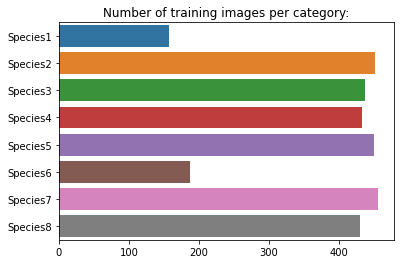

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
og_dataset = './splitted/train'
category_names = sorted(os.listdir(og_dataset))
nb_categories = len(category_names)
img_pr_cat = []
maxImgCat = 0
for category in category_names:
    folder = og_dataset + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
    if len(os.listdir(folder)) > maxImgCat:
      maxImgCat = len(os.listdir(folder))
print(maxImgCat)
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=20,
                                        height_shift_range=0.2,
                                        width_shift_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        vertical_flip=False, 
                                        fill_mode='reflect',
                                        brightness_range=[0.9,1.5],
                                        cval=0,
                                        preprocessing_function = preprocess_input,
                                        ) 
valid_data_gen = ImageDataGenerator(
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(
                                   preprocessing_function = preprocess_input)

In [ ]:
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, 
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, 
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 3007 images belonging to 8 classes.
Found 535 images belonging to 8 classes.
Found 535 images belonging to 8 classes.


In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):
  callbacks = []
  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [ ]:

# Download and plot the EfficientNet model

supernet = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3),
)
supernet.summary()
tfk.utils.plot_model(supernet)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
input_shape = (96, 96, 3)
epochs = 200

In [ ]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
x = supernet(inputs)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tfkl.Dropout(0.4, seed=seed)(x)
x=tf.keras.layers.Dense(units=1024, activation='leaky_relu')(x)
x = tfkl.Dropout(0.2, seed=seed)(x)
output_layer = tfkl.Dense(units=len(labels), activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0     

In [ ]:
for i, layer in enumerate(tl_model.get_layer('efficientnetv2-m').layers):
   layer.trainable = False


In [ ]:
class_weight = {0:2.8,1:1.,2:1.,3:1.,4:1.,5:2.,6:1.,7:1.}
for i in range(len(labels)):
  path = "/content/splitted/train/Species"+str(i+1)
  print(path)
  class_weight[i] = maxImgCat/len(os.listdir(path))
print(class_weight)

/content/splitted/train/Species1
/content/splitted/train/Species2
/content/splitted/train/Species3
/content/splitted/train/Species4
/content/splitted/train/Species5
/content/splitted/train/Species6
/content/splitted/train/Species7
/content/splitted/train/Species8
{0: 2.8860759493670884, 1: 1.008849557522124, 2: 1.0434782608695652, 3: 1.0506912442396312, 4: 1.0110864745011086, 5: 2.425531914893617, 6: 1.0, 7: 1.0580046403712298}


In [ ]:
tl_callbacks = create_folders_and_callbacks(model_name = 'tl_effNet_con_preprocessing_learning_rate_basso')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight=class_weight,
    callbacks = tl_callbacks,
).history

Epoch 1/200
94/94 [==============================] - 16s 165ms/step - loss: 1.3136 - accuracy: 0.6152 - precision: 0.7467 - recall: 0.4559 - val_loss: 0.9818 - val_accuracy: 0.6692 - val_precision: 0.7704 - val_recall: 0.5458
Epoch 2/200
94/94 [==============================] - 14s 144ms/step - loss: 1.2864 - accuracy: 0.6309 - precision: 0.7530 - recall: 0.4766 - val_loss: 0.9771 - val_accuracy: 0.6636 - val_precision: 0.7664 - val_recall: 0.5888
Epoch 3/200
94/94 [==============================] - 14s 145ms/step - loss: 1.2989 - accuracy: 0.6116 - precision: 0.7500 - recall: 0.4519 - val_loss: 0.9770 - val_accuracy: 0.6523 - val_precision: 0.7690 - val_recall: 0.5477
Epoch 4/200
94/94 [==============================] - 14s 145ms/step - loss: 1.2838 - accuracy: 0.6222 - precision: 0.7395 - recall: 0.4662 - val_loss: 0.9611 - val_accuracy: 0.6710 - val_precision: 0.7781 - val_recall: 0.5439
Epoch 5/200
94/94 [==============================] - 14s 144ms/step - loss: 1.2940 - accuracy: 0

17/17 [==============================] - 5s 68ms/step
[0 1 7 0 6 5 0 0 5 0 7 1 1 1 7 0 0 7 0 0 3 3 0 7 0 7 4 0 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 0 0 1 7 0 1 1 1 1 6 1 1 1 1 6 1 1 1 1 3 1 1 6 0 1 1 1 1 3 1 1 6
 1 1 1 5 1 1 1 7 1 1 1 1 1 7 1 5 1 1 7 1 1 1 1 1 6 1 1 1 1 6 1 1 1 3 2 2 2
 2 2 2 2 2 3 6 2 2 7 2 2 2 2 2 3 2 2 2 2 2 2 0 2 2 2 4 2 2 2 4 4 2 2 4 2 2
 2 2 2 2 2 0 2 2 2 4 0 2 2 3 2 2 2 2 2 2 2 2 2 6 4 2 2 4 2 2 2 2 2 2 2 4 4
 2 3 3 3 3 7 7 3 3 3 4 3 3 3 7 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 3 7 3 0 3
 5 3 3 0 3 3 3 3 3 3 7 3 2 3 7 3 3 3 4 2 3 3 3 3 3 3 4 3 3 1 3 3 3 3 3 3 2
 3 6 3 4 2 2 4 4 4 4 4 4 2 4 3 2 4 4 4 4 2 2 3 4 4 4 4 4 4 4 2 3 2 2 4 3 2
 4 3 4 4 4 4 4 4 2 4 4 4 2 0 4 4 2 4 4 4 4 4 4 4 2 4 4 4 4 2 4 4 2 4 4 4 4
 3 4 4 4 4 4 4 4 3 4 5 7 5 5 5 5 5 1 5 5 5 5 5 6 5 5 5 5 1 5 5 1 5 5 5 5 5
 5 1 5 5 1 1 5 4 1 6 6 6 6 6 6 6 6 6 6 6 6 6 1 6 6 6 6 1 6 6 6 1 6 2 6 6 6
 1 1 6 2 6 6 6 6 6 6 1 6 1 2 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 2 1 6 6 6 4 6
 6 1 1 6 6 1 6 2 6 1 6 7 4 6 1 3 4 7 7 7 3 4 7

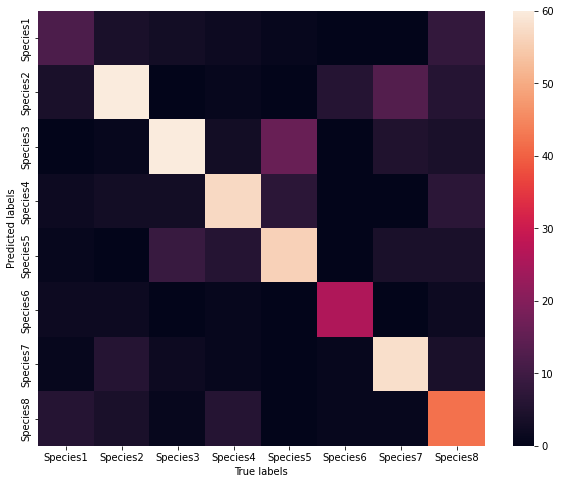

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))

              precision    recall  f1-score   support

           0       0.40      0.43      0.41        28
           1       0.67      0.75      0.71        80
           2       0.67      0.77      0.72        78
           3       0.72      0.74      0.73        77
           4       0.70      0.70      0.70        80
           5       0.79      0.76      0.78        34
           6       0.79      0.72      0.75        81
           7       0.69      0.55      0.61        77

    accuracy                           0.69       535
   macro avg       0.68      0.68      0.68       535
weighted avg       0.70      0.69      0.69       535



In [ ]:
# Save the best model
tl_model.save('/gdrive/MyDrive/Challenge1/EfficientNet/efficent_net_v2_1024d')

In [ ]:
# Re-load the model after transfer learning
tl_model = tfk.models.load_model('/gdrive/MyDrive/Challenge1/EfficientNet/efficent_net_v2')
tl_model.summary()

In [ ]:
# Set all EffNet layers to True
tl_model.get_layer('efficientnetv2-m').trainable = True
for i, layer in enumerate(tl_model.get_layer('efficientnetv2-m').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
for i, layer in enumerate(tl_model.get_layer('efficientnetv2-m').layers[:500]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('efficientnetv2-m').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block2a_expand_conv False
20 block2a_expand_bn False
21 block2a_expand_activation False
22 block2a_project_conv False
23 block2a_project_bn False
24 block2b_expand_conv False
25 block2b_expand_bn False
26 block2b_expand_activation False
27 block2b_project_conv False
28 block2b_project_bn False
29 block2b_drop False
30 block2b_add False
31 block2c_expand_conv False
32 block2c_expand_bn False
33 block2c_expand_activation False
34 block2c_project_conv False
35 block2c_project_bn False
36 block2c_drop False
37 block2c_a

In [ ]:
# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model

tl_callbacks = create_folders_and_callbacks(model_name = 'fine_tuning_after_transfer')

tl_history = tl_model.fit(
    x = aug_train_gen ,
    epochs = 200,
    validation_data = valid_gen,
    class_weight=class_weight,
    callbacks = tl_callbacks,
).history

Epoch 1/200
94/94 [==============================] - 38s 198ms/step - loss: 1.2379 - accuracy: 0.6315 - precision_1: 0.7424 - recall_1: 0.4859 - val_loss: 0.9122 - val_accuracy: 0.6916 - val_precision_1: 0.7855 - val_recall_1: 0.5888
Epoch 2/200
94/94 [==============================] - 16s 169ms/step - loss: 1.2418 - accuracy: 0.6362 - precision_1: 0.7510 - recall_1: 0.5005 - val_loss: 0.9139 - val_accuracy: 0.6935 - val_precision_1: 0.7873 - val_recall_1: 0.5813
Epoch 3/200
94/94 [==============================] - 13s 141ms/step - loss: 1.2681 - accuracy: 0.6325 - precision_1: 0.7586 - recall_1: 0.4995 - val_loss: 0.9268 - val_accuracy: 0.6748 - val_precision_1: 0.7816 - val_recall_1: 0.5888
Epoch 4/200
94/94 [==============================] - 13s 141ms/step - loss: 1.2783 - accuracy: 0.6192 - precision_1: 0.7392 - recall_1: 0.4845 - val_loss: 0.9364 - val_accuracy: 0.6822 - val_precision_1: 0.7764 - val_recall_1: 0.5776
Epoch 5/200
94/94 [==============================] - 16s 168ms/s

In [ ]:
tl_model.save('/gdrive/MyDrive/Challenge1/EfficientNet/efficient_net_ft')

In [ ]:
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)


17/17 [==============================] - 1s 75ms/step - loss: 0.8457 - accuracy: 0.7121 - precision_1: 0.7976 - recall_1: 0.6187

Test metrics
{'loss': 0.8456867337226868, 'accuracy': 0.7121495604515076, 'precision_1': 0.7975903749465942, 'recall_1': 0.6186915636062622}


17/17 [==============================] - 1s 70ms/step
[0 1 7 0 6 5 3 0 5 0 7 1 1 6 7 0 4 7 0 0 3 3 7 0 0 7 4 0 1 1 1 1 1 1 1 1 6
 1 1 2 1 1 1 0 1 7 0 1 6 1 1 6 1 1 1 1 6 1 1 1 1 3 1 1 6 0 1 1 1 1 3 1 1 6
 1 1 6 5 1 1 1 7 1 1 1 1 1 1 1 6 6 1 7 1 1 1 1 1 6 1 1 1 1 6 1 1 1 3 2 2 2
 2 2 2 2 2 2 6 2 2 7 2 2 2 2 2 3 2 2 2 2 2 2 0 2 2 2 4 2 2 2 4 2 2 2 5 2 2
 2 2 2 2 2 0 2 2 2 4 3 2 2 3 2 2 2 2 2 2 2 2 2 6 3 2 2 4 4 2 2 2 2 2 2 4 4
 2 3 3 3 3 7 3 3 7 3 4 3 3 3 7 3 3 3 3 3 3 4 3 3 3 6 3 3 3 3 3 4 3 7 3 0 3
 5 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 4 2 3 3 3 3 3 3 4 3 3 1 3 3 3 3 3 3 3
 3 6 3 3 2 2 4 4 4 4 4 4 2 4 3 2 4 4 4 4 2 2 3 4 4 4 4 4 4 4 2 3 2 2 4 3 2
 4 3 4 4 4 4 4 4 2 4 4 4 4 2 4 4 0 4 4 4 4 4 4 4 2 4 4 4 4 3 4 4 2 4 4 4 4
 3 4 4 4 4 4 4 4 3 4 5 5 5 5 5 5 5 1 5 5 5 5 5 6 5 5 5 5 5 5 5 1 5 5 5 5 5
 5 5 5 5 1 1 5 4 1 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 1 6 6 2 6 6 6 6 6 6 1 6 6 2 6 6 4 6 6 6 6 6 6 6 6 6 6 6 6 6 2 1 6 6 6 4 6
 6 1 1 6 6 6 6 2 6 6 6 7 4 6 1 3 4 3 7 7 3 0 7

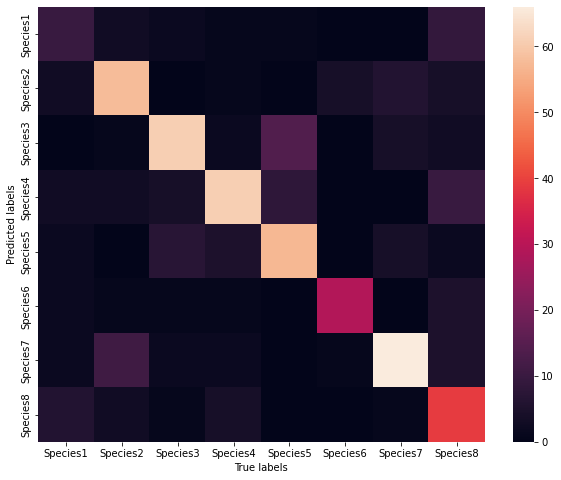

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict(test_gen)
predicted_classes = np.argmax(predictions, axis=-1)
print(predicted_classes)

# Compute the confusion matrix

cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes, normalize = True)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()



In [ ]:
import sklearn.metrics
print(sklearn.metrics.classification_report(test_gen.classes, predicted_classes,output_dict = False))